# Resnet

In [1]:

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gc
import numpy as np

from keras import backend as K
from sklearn.metrics import fbeta_score
from keras.layers import Conv2D, Dense, LSTM, Flatten, MaxPooling2D, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
from sklearn.utils import shuffle

import cv2
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 

import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History

In [2]:

path = pd.read_csv(r"C:\Users\clemi\Downloads\planet-understanding-the-amazon-from-space\train_v2.csv\train_v2.csv")#Place the train.csv file

#Two lists to store images and labels
x_train = []
y_train = []

# Flatten the list of tags
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in path['tags'].values])))

# Create a label map for the unique tags in the dataset
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Loop through the training DataFrame
for f, tags in tqdm(path.values, miniters=1000):
    # Read the image file
    img = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\train-jpg\train-jpg/{}.jpg'.format(f))
    # Resize the image to (64, 64)
    targets = np.zeros(17)
    # Loop through the additional test files DataFrame
    for t in tags.split(' '):
        # Set the corresponding target value to 1
        targets[label_map[t]] = 1 
    # Resize the image to (64, 64)
    x_train.append(cv2.resize(img, (64, 64)))  
    y_train.append(targets)


x_train = np.array(x_train, np.float16) / 255.
y_train = np.array(y_train, np.uint8)

100%|███████████████████████████████████████████████████████████████████████████| 40479/40479 [01:05<00:00, 620.08it/s]


In [3]:
#Separating training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3, shuffle = True, random_state = 1)

print("Train data shape:",x_train.shape)
print("Train label shape:",y_train.shape)

print("Validation data shape:",x_val.shape)
print("Validation label shape:",y_val.shape)


Train data shape: (32383, 64, 64, 3)
Train label shape: (32383, 17)
Validation data shape: (8096, 64, 64, 3)
Validation label shape: (8096, 17)


In [4]:
# Evaluation Metric
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    y_pred = K.clip(y_pred, 0, 1)

    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [5]:
# ResNet50
from tensorflow.keras.applications import ResNet50

def ResNet():
    #Load the MobileNet architecture ResNet50 
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    # Freeze MobileNet weights so they are not updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Add additional layers on top of ResNet50
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(17, activation='sigmoid')(x)

    # Create the final model
    model_resnet = Model(inputs=base_model.input, outputs=predictions)


    # compile the model
    model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])
    return model_resnet
#Calling the previously created function
model_resnet = ResNet()

# Traning Model
historyResNet = model_resnet.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=256)


Epoch 1/10
127/127 [==============================] - 135s 1s/step - loss: 0.2732 - fbeta: 0.5978 - val_loss: 0.2493 - val_fbeta: 0.6100
Epoch 2/10
127/127 [==============================] - 132s 1s/step - loss: 0.2494 - fbeta: 0.6037 - val_loss: 0.2445 - val_fbeta: 0.6106
Epoch 3/10
127/127 [==============================] - 135s 1s/step - loss: 0.2448 - fbeta: 0.6050 - val_loss: 0.2401 - val_fbeta: 0.6126
Epoch 4/10
127/127 [==============================] - 132s 1s/step - loss: 0.2409 - fbeta: 0.6071 - val_loss: 0.2366 - val_fbeta: 0.6159
Epoch 5/10
127/127 [==============================] - 131s 1s/step - loss: 0.2376 - fbeta: 0.6097 - val_loss: 0.2339 - val_fbeta: 0.6176
Epoch 6/10
127/127 [==============================] - 132s 1s/step - loss: 0.2347 - fbeta: 0.6121 - val_loss: 0.2321 - val_fbeta: 0.6198
Epoch 7/10
127/127 [==============================] - 135s 1s/step - loss: 0.2323 - fbeta: 0.6144 - val_loss: 0.2296 - val_fbeta: 0.6218
Epoch 8/10
127/127 [=====================

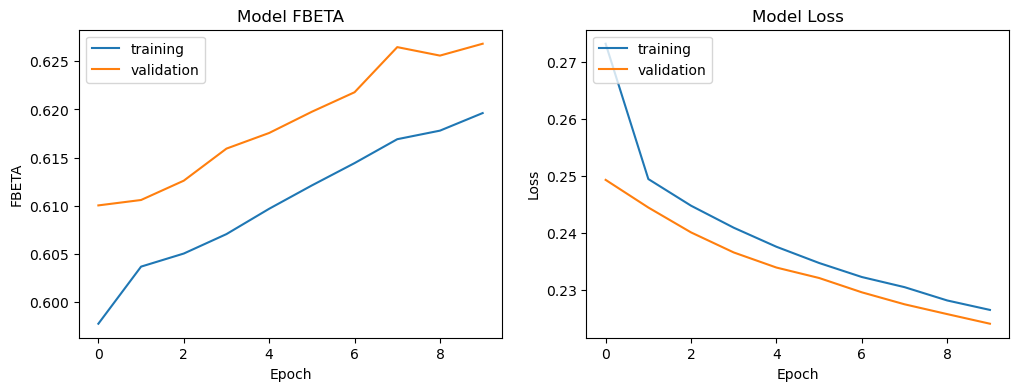

In [6]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historyResNet.history['fbeta'])
plt.plot(historyResNet.history['val_fbeta'])
plt.title('Model FBETA')
plt.ylabel('FBETA')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(historyResNet.history['loss'])
plt.plot(historyResNet.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [7]:
# Loading the test images
samplesub = pd.read_csv(r"C:\Users\clemi\Downloads\Sidia\sample_submission_v2.csv")

test = samplesub[0 : 40669]
files = samplesub[40669 : ]


# Initialize an empty list to store the images
x_test = []
y_test = []
# Loop through the test DataFrame

for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg\test-jpg\test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)
    
for image_name, tags in tqdm(files.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg-additional\test-jpg-additional/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)

# Convert the list of images to a numpy array and normalize the pixel values
x_test = np.array(x_test, np.float16)/255.0

100%|███████████████████████████████████████████████████████████████████████████| 20522/20522 [00:41<00:00, 497.83it/s]


In [8]:
# test dataset
y_test = np.array(y_test, np.uint8)

_, x_test, _, y_test = train_test_split(x_test, y_test, test_size = 0.3, shuffle = True, random_state = 1)

print("test data shape:",x_test.shape)
print("test label shape:",y_test.shape)

test data shape: (18358, 64, 64, 3)
test label shape: (18358, 17)


In [11]:
# Evaluate the model on the test set
test_loss,test_fbeta = model_resnet.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test F-beta:", test_fbeta)

574/574 [==============================] - 73s 127ms/step - loss: 0.5523 - fbeta: 0.3329
Test Loss: 0.5523061156272888
Test F-beta: 0.33290836215019226


In [13]:
#  Evaluate the model on the val set
val_loss,val_fbeta = model_resnet.evaluate(x_val, y_val)
print("Val Loss:", val_loss)
print("Val F-beta:", val_fbeta)

253/253 [==============================] - 32s 125ms/step - loss: 0.2241 - fbeta: 0.6277
Val Loss: 0.22407612204551697
Val F-beta: 0.6277129650115967
